In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 117, Finished, Available)

In [118]:
# Load mlflow rf prediction
mlflow_rf_prediction = spark.sql("SELECT * FROM Gold.mlflow_rf_prediction")

# Load mlflow rf training
mlflow_rf_training = spark.sql("SELECT * FROM Gold.mlflow_rf_training")

# Load tensorflow keras prediction
tfkeras_prediction = spark.sql("SELECT * FROM Gold.tfkeras_prediction")

# Load tensorflow keras training
tfkeras_training = spark.sql("SELECT * FROM Gold.tfkeras_training")

# Load tensorflow keras training
train = spark.sql("SELECT * FROM Gold.train")

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 118, Finished, Available)

In [119]:
# Checking training data shape
print((mlflow_rf_training.count(), len(mlflow_rf_training.columns)))
print((tfkeras_training.count(), len(tfkeras_training.columns)))

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 119, Finished, Available)

(438, 11)
(438, 13)


In [120]:
mlflow_rf_training.columns

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 120, Finished, Available)

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'SalePRice',
 'PredictedPrice']

In [135]:
from pyspark.sql.types import StructType, StructField, LongType

def with_column_index(sdf): 
    new_schema = StructType(sdf.schema.fields + [StructField("ColumnIndex", LongType(), False),])
    return sdf.rdd.zipWithIndex().map(lambda row: row[0] + (row[1],)).toDF(schema=new_schema)

df1_ci = with_column_index(mlflow_rf_training.orderBy('SalePRice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt')['SalePRice', 'PredictedPrice'].withColumnRenamed('SalePRice', 'temp'))
df2_ci = with_column_index(tfkeras_training.orderBy('SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'))
joined_predictions = df2_ci.join(df1_ci, df2_ci.ColumnIndex == df1_ci.ColumnIndex, 'inner').withColumnRenamed('PredictedPrice','rf_prediction_mlflow')


display(joined_predictions)

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 135, Finished, Available)

SynapseWidget(Synapse.DataFrame, 02907740-1c42-46be-bf21-d7db70a9f5f8)

In [136]:
joined_predictions = joined_predictions.drop('temp')
joined_predictions.columns

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 136, Finished, Available)

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'rf_prediction',
 'gb_prediction',
 'cart_prediction',
 'ColumnIndex',
 'rf_prediction_mlflow',
 'ColumnIndex']

In [137]:
display(joined_predictions)

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 137, Finished, Available)

SynapseWidget(Synapse.DataFrame, e476db76-9dcc-4f50-9fa1-686ac571b236)

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 148, Finished, Available)

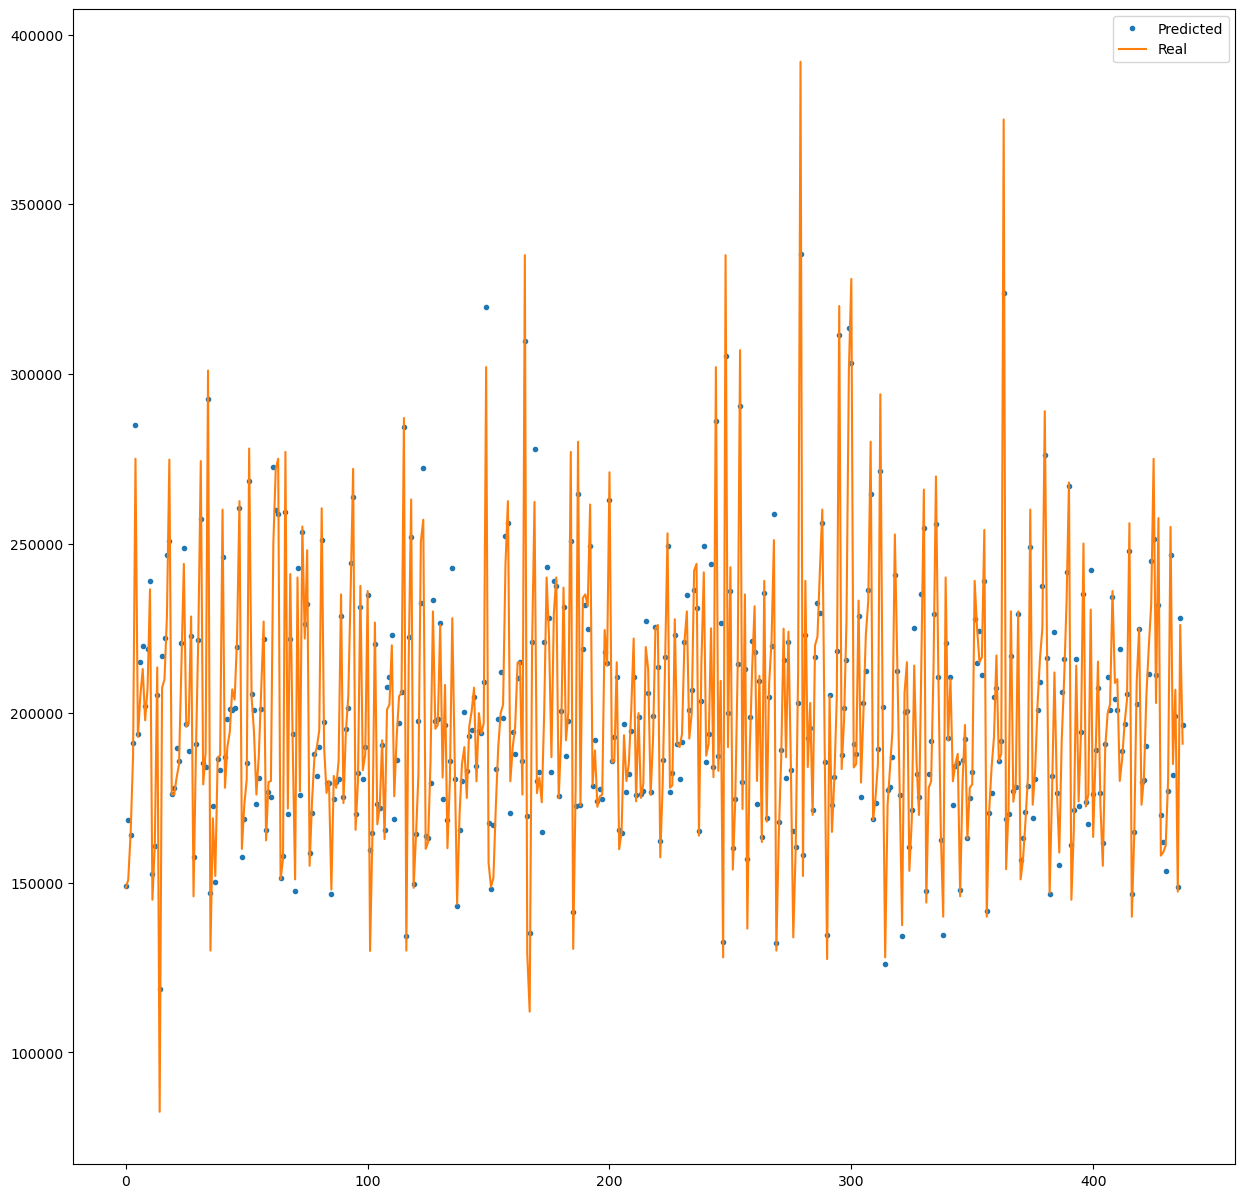

In [148]:
joined_predictions_pandas = joined_predictions.toPandas()
joined_predictions_pandas

plt.figure(figsize=(15, 15))
plt.plot(joined_predictions_pandas.index.values, joined_predictions_pandas["rf_prediction_mlflow"], '.', label = "Predicted")
plt.plot(joined_predictions_pandas.index.values, joined_predictions_pandas["SalePrice"], '-', label = "Real")
plt.legend()
plt.show()


StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 156, Finished, Available)

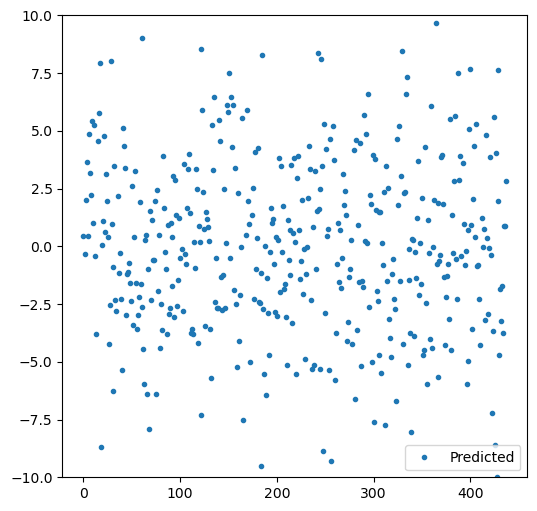

In [156]:
joined_predictions_pandas = joined_predictions.toPandas()
joined_predictions_pandas

plt.figure(figsize=(6, 6))
x = joined_predictions_pandas.index.values
y = (joined_predictions_pandas.rf_prediction_mlflow.values- joined_predictions_pandas.SalePrice.values)/joined_predictions_pandas.SalePrice.values*100
plt.plot(x, y, '.', label = "Predicted")
plt.legend()
plt.ylim([-10,10])
plt.show()


StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 161, Finished, Available)

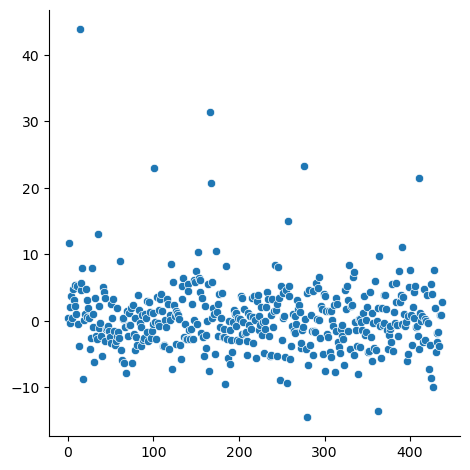

In [161]:
sns.relplot(y)

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 158, Finished, Available)

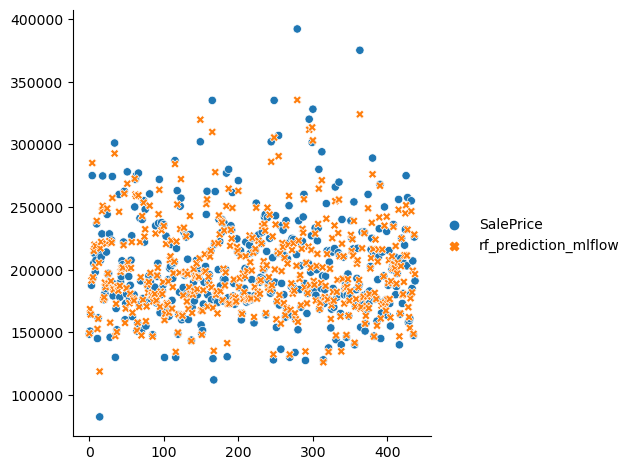

In [158]:
import seaborn as sns
sns.relplot(data=joined_predictions_pandas[['SalePrice', 'rf_prediction_mlflow']])

In [177]:
mlflow_rf_training.toPandas()

StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 177, Finished, Available)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,SalePRice,PredictedPrice
0,6,1458,2,440,729,729,2,5,1999,176000,174614.860000
1,6,958,2,440,1078,958,2,5,1976,128000,132422.750000
2,6,1525,2,440,756,769,2,5,2000,177000,175912.000000
3,6,1573,2,440,756,769,2,5,2000,177500,176500.000000
4,6,958,2,440,958,958,2,5,1976,143750,143021.500000
...,...,...,...,...,...,...,...,...,...,...,...
433,7,1728,2,572,864,864,2,7,2004,190000,194374.750000
434,7,1710,2,550,1710,1710,2,7,2004,240000,242726.740000
435,7,1709,2,380,970,970,2,7,2004,137500,134345.435714
436,7,1708,2,380,976,976,2,7,2004,130000,132320.650000


StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 189, Finished, Available)

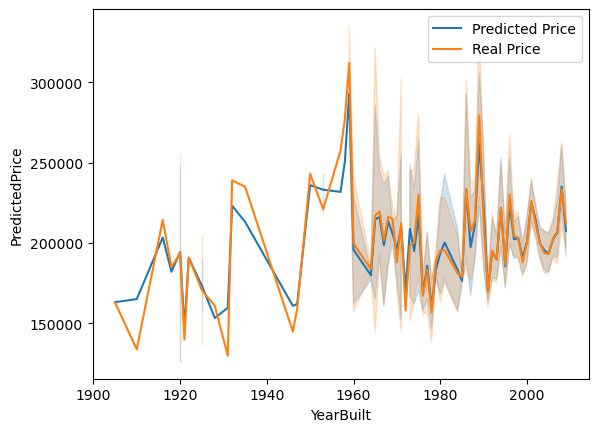

In [189]:
plt.figure()
sns.lineplot(x = "YearBuilt", y = "PredictedPrice", data = mlflow_rf_training.toPandas(), label='Predicted Price')
sns.lineplot(x = "YearBuilt", y = "SalePRice", data = mlflow_rf_training.toPandas(), label='Real Price')
plt.show()


StatementMeta(, a6d4fb22-120a-493f-8fa0-fa8900e8d216, 188, Finished, Available)

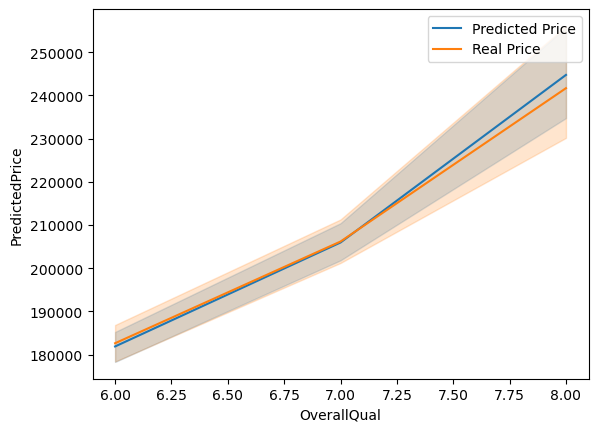

In [188]:
plt.figure()
sns.lineplot(x = "OverallQual", y = "PredictedPrice", data = mlflow_rf_training.toPandas(), label='Predicted Price')
sns.lineplot(x = "OverallQual", y = "SalePRice", data = mlflow_rf_training.toPandas(), label='Real Price')
plt.legend()
plt.show()